**DSA210 Term Project**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind, chi2_contingency
import statsmodels.api as sm

**1. Load Data**

In [3]:
file_path= "DSA210_PROJECT_DATA.xlsx" 
df = pd.read_excel(file_path)
df.head()

,DATE,Body Weight (kg),Body Fat Percentage (%),Daily Calorie Intake,Daily Protein Intake(g),Daily Carbohydrate Intake(g),Daily Fat Intake(g),Sleep Duration (hours),Sleep Quality,Exercise Time (minutes),Water Intake (L)
0,6/2/2025,70.80,31.50,1349.0,111.47,143.67,34.65,5.0,1,0,1.5
1,7/2/2025,70.56,31.41,1591.0,72.62,186.22,46.20,7.0,1,110,2.0
2,8/2/2025,70.46,31.35,1571.0,132.24,149.54,51.03,8.0,2,60,2.5
3,9/2/2025,70.32,31.28,1638.0,131.25,119.85,83.36,9.0,3,0,3.0
4,10/2/2025,70.23,31.22,1211.0,NaN,120.54,52.14,10.0,4,0,3.5


**2. Data Cleaning**

In [4]:
#Convert date column
df["DATE"] = pd.to_datetime(df["DATE"], dayfirst= True)

In [5]:
#Check missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 DATE                             0
Body Weight (kg)                 0
Body Fat Percentage (%)          0
Daily Calorie Intake             7
Daily Protein Intake(g)         10
Daily Carbohydrate Intake(g)     9
Daily Fat Intake(g)             10
Sleep Duration (hours)           6
Sleep Quality                    0
Exercise Time (minutes)          0
Water Intake (L)                 5
dtype: int64


In [6]:
# Fill missing values with column means , mean is valid because calorie and water columns has NaN values 
df.fillna(df.mean(numeric_only=True), inplace=True)

**3. Feature Engineering**

In [7]:
# Daily change in body fat percentage
df["Fat % Change"] = df["Body Fat Percentage (%)"].diff()
# Daily change in body weight
df["Weight Change"] = df["Body Weight (kg)"].diff()
# Calculate calorie deficit 
df["Calorie Deficit (kcal)"] = 2300 - (df["Daily Calorie Intake"] - df["Exercise Time (minutes)"] * 4)
# Add a column for protein ratio (protein intake / total calories)
df["Protein Ratio"] = df["Daily Protein Intake(g)"] / df["Daily Calorie Intake"]


**4.Summary statistics to get a general idea:**

In [8]:
df.describe()

,DATE,Body Weight (kg),Body Fat Percentage (%),Daily Calorie Intake,Daily Protein Intake(g),Daily Carbohydrate Intake(g),Daily Fat Intake(g),Sleep Duration (hours),Sleep Quality,Exercise Time (minutes),Water Intake (L),Fat % Change,Weight Change,Calorie Deficit (kcal),Protein Ratio
count,78,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,77.000000,77.000000,78.000000,78.000000
mean,2025-03-16 12:00:00,67.402692,29.137949,1476.338028,77.741471,166.024493,52.069412,7.666667,2.346154,48.076923,2.438356,-0.059091,-0.088312,1015.969664,0.053783
min,2025-02-06 00:00:00,63.800000,26.950000,899.000000,31.630000,90.050000,25.280000,5.000000,1.000000,0.000000,1.500000,-0.420000,-0.400000,280.000000,0.022214
25%,2025-02-25 06:00:00,66.297500,27.887500,1324.250000,65.487500,142.225000,45.265000,6.250000,1.000000,0.000000,2.000000,-0.070000,-0.200000,830.246479,0.043187
50%,2025-03-16 12:00:00,67.150000,29.060000,1414.000000,76.545000,156.800000,52.069412,7.833333,2.000000,30.000000,2.500000,-0.060000,-0.100000,1000.000000,0.051996
75%,2025-04-04 18:00:00,68.822500,30.265000,1569.000000,82.695000,167.530000,55.765000,9.000000,3.750000,100.000000,3.000000,-0.060000,-0.040000,1184.750000,0.060240
max,2025-04-24 00:00:00,70.800000,31.500000,2500.000000,150.000000,340.000000,87.020000,10.000000,5.000000,120.000000,3.500000,0.350000,0.430000,1456.000000,0.115385
std,NaN,1.826059,1.347636,279.548985,23.066925,46.500119,12.821006,1.496750,1.384768,50.991665,0.669101,0.108023,0.185610,255.099341,0.017240


**5.Data Visualization**

**Correlation Matrix**

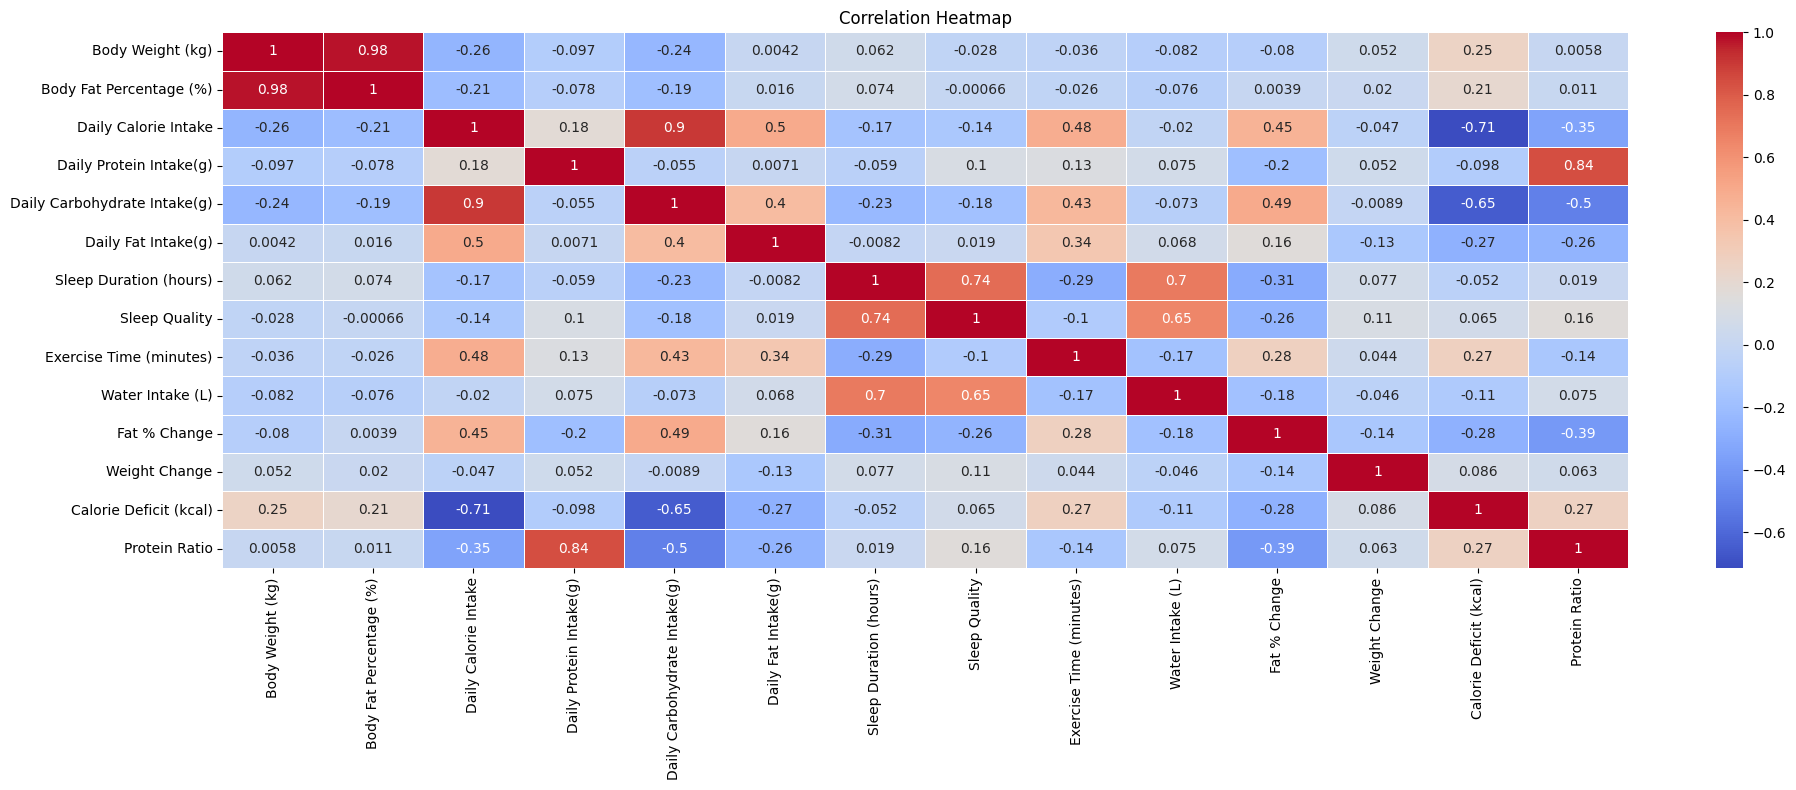

In [9]:
plt.figure(figsize=(20, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

➡️ **Body Weight** and **Body Fat %** were highly correlated (r = 0.98), indicating that reductions in weight strongly aligned with reductions in fat mass.

➡️ Variables like **Sleep Duration**, **Water Intake**, and **Exercise Time** showed weak or negligible correlations with fat change, suggesting they may not have had immediate measurable impact.


**Time‑series Plot: Body Weight & Body Fat %**

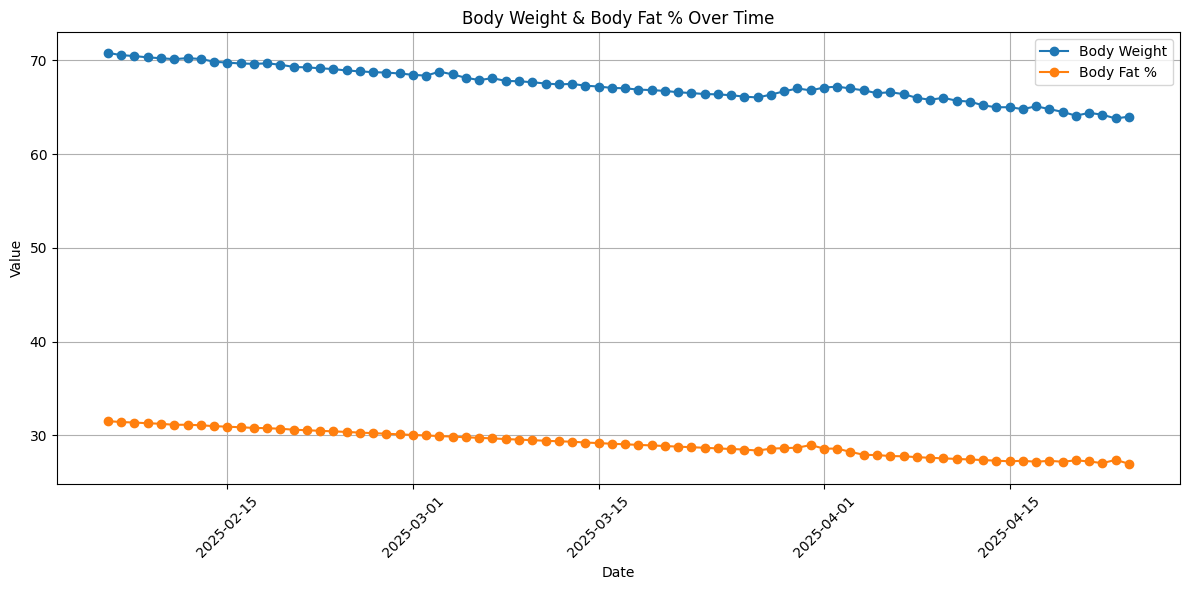

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df["DATE"], df["Body Weight (kg)"], label="Body Weight", marker="o")
plt.plot(df["DATE"], df["Body Fat Percentage (%)"], label="Body Fat %", marker="o")
plt.title("Body Weight & Body Fat % Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

📊 Both body weight and body fat percentage showed a steady decline over the 3-month period, suggesting consistent progress in fat reduction and weight loss.

**Boxplots: Daily Calorie & Protein Intake Distributions**

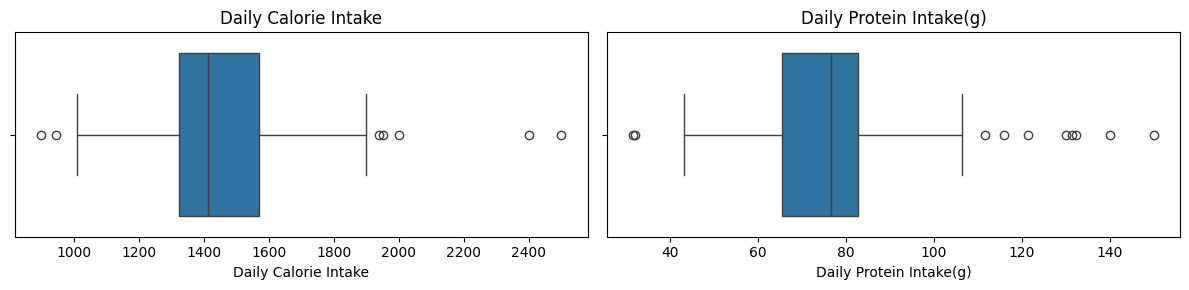

In [11]:
cols = ["Daily Calorie Intake", "Daily Protein Intake(g)"]
fig, axes = plt.subplots(1, 2, figsize=(12, 3))  
for ax, col in zip(axes.flatten(), cols):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f"{col}")
plt.tight_layout()
plt.show()

📊 **Daily Calorie Intake** and **Protein Intake** were generally centered around ~1400 kcal and ~80g respectively.

✅ Both variables included moderate outliers on the higher end, especially for protein intake, indicating occasional dietary spikes. Despite outliers, the majority of data points were within a relatively narrow interquartile range, suggesting consistent intake behavior.

**Scatterplots with Regression Lines: Visualizing the relationships between key predictors and body composition metrics**


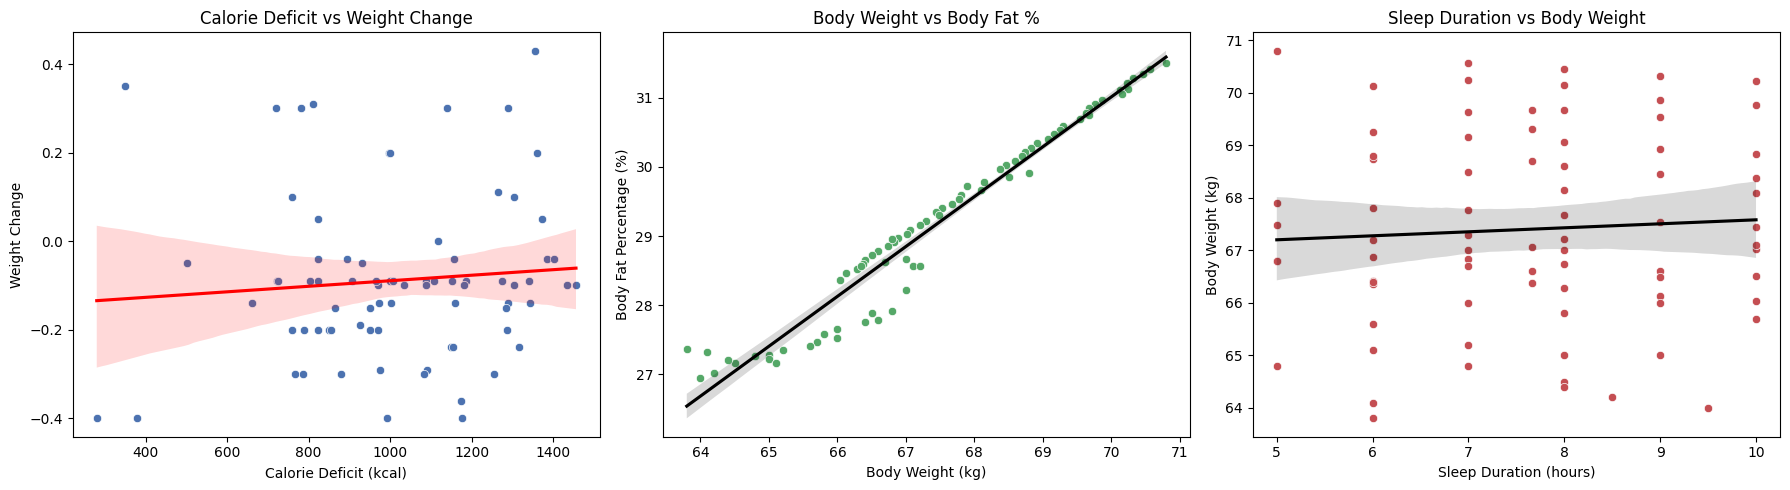

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

# Plot 1: Calorie Deficit vs Weight Change
sns.scatterplot(x="Calorie Deficit (kcal)", y="Weight Change", data=df, ax=axes[0], color="#4C72B0")
sns.regplot(x="Calorie Deficit (kcal)", y="Weight Change", data=df, ax=axes[0], scatter=False, color="red")
axes[0].set_title("Calorie Deficit vs Weight Change")

# Plot 2: Body Weight vs Body Fat %
sns.scatterplot(x="Body Weight (kg)", y="Body Fat Percentage (%)", data=df, ax=axes[1], color="#55A868")
sns.regplot(x="Body Weight (kg)", y="Body Fat Percentage (%)", data=df, ax=axes[1], scatter=False, color="black")
axes[1].set_title("Body Weight vs Body Fat %")

# Plot 3: Sleep Duration vs Body Weight
sns.scatterplot(x="Sleep Duration (hours)", y="Body Weight (kg)", data=df, ax=axes[2], color="#C44E52")
sns.regplot(x="Sleep Duration (hours)", y="Body Weight (kg)", data=df, ax=axes[2], scatter=False, color="black")
axes[2].set_title("Sleep Duration vs Body Weight")

plt.tight_layout()
plt.show()

➡️ **1. Calorie Deficit vs Weight Change**  
A weak positive trend is visible, but the wide confidence interval suggests low predictive power. This indicates that same-day calorie deficit does not reliably predict immediate weight change.

➡️ **2. Body Weight vs Body Fat %**  
A very strong linear correlation is evident (r ≈ 0.98), showing that reductions in weight closely mirror reductions in body fat percentage.

➡️ **3. Sleep Duration vs Body Weight**  
There is no significant trend, indicating sleep duration alone is not strongly associated with variations in body weight in this dataset.


**Boxplots: Calorie Group vs Body Weight**

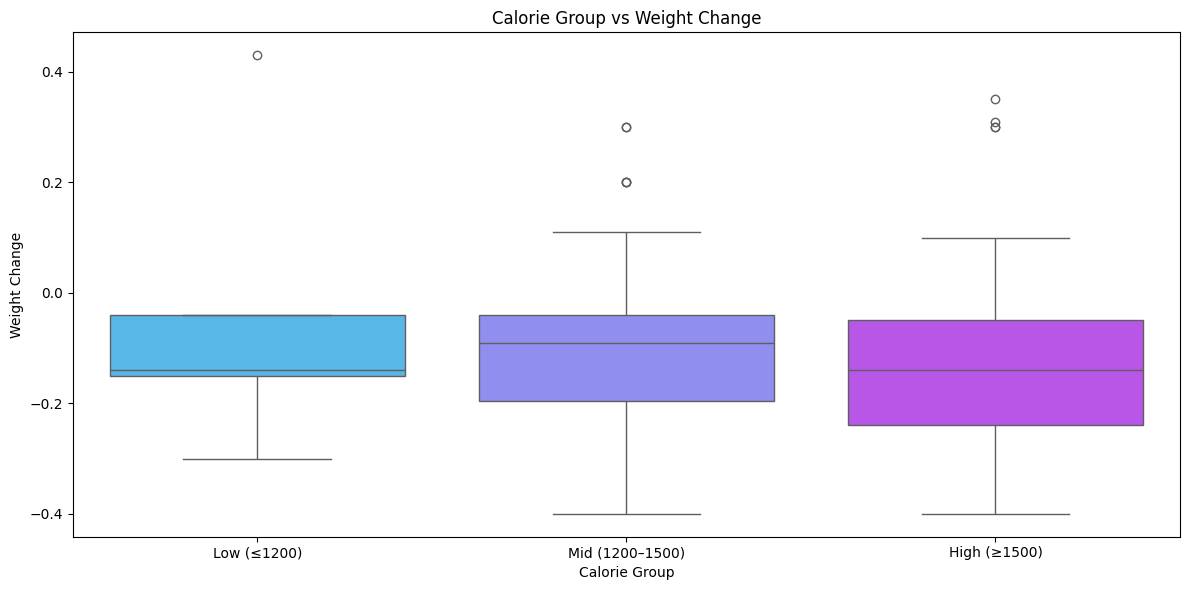

In [13]:
cal_groups = pd.cut(df["Daily Calorie Intake"],bins=[0, 1200, 1500, 10000],labels=["Low (≤1200)", "Mid (1200–1500)", "High (≥1500)"])

df["Calorie Group"] = cal_groups

plt.figure(figsize=(12, 6))
sns.boxplot(x="Calorie Group", y="Weight Change", hue="Calorie Group", data=df, palette="cool", legend=False)
plt.title("Calorie Group vs Weight Change")
plt.tight_layout()
plt.show()

➡️ Surprisingly, even on high-calorie days (≥1500 kcal), I often experienced weight loss, possibly due to physical activity or delayed metabolic effects.

➡️ The mid-calorie range (1200–1500 kcal) showed the greatest variability in both body weight and weight change.

➡️ Interestingly, the low-calorie group (≤1200 kcal) did not consistently result in the greatest weight reduction, highlighting that short-term restriction may not linearly translate to immediate loss.

**Daily Calorie Intake vs Exercise Duration**

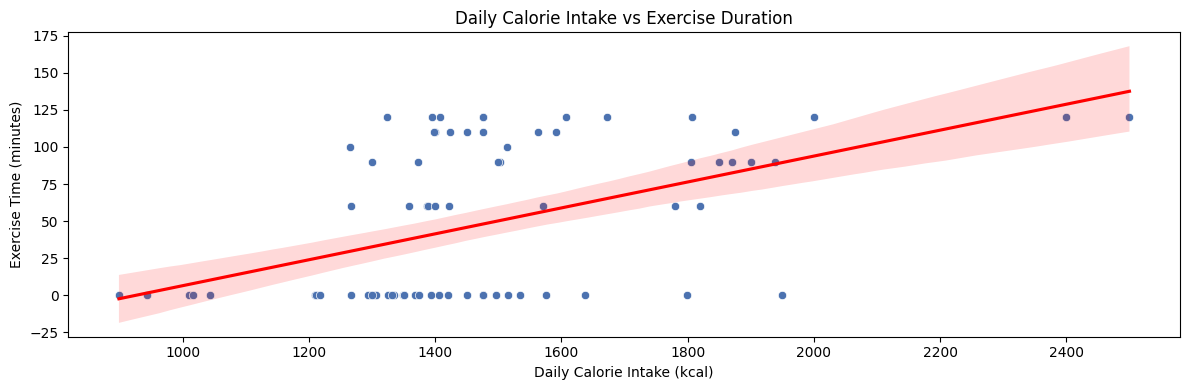

In [14]:
plt.figure(figsize=(12, 4))
sns.scatterplot(x="Daily Calorie Intake", y="Exercise Time (minutes)", data=df, color="#4C72B0")
sns.regplot(x="Daily Calorie Intake", y="Exercise Time (minutes)", data=df, scatter=False, color="red")
plt.title("Daily Calorie Intake vs Exercise Duration")
plt.xlabel("Daily Calorie Intake (kcal)")
plt.ylabel("Exercise Time (minutes)")
plt.tight_layout()
plt.show()

📊 This plot shows that higher daily calorie intake is generally associated with longer exercise durations.

✅ This observation helps explain why weight loss can still occur on high-calorie days—because they often coincide with more exercise, offsetting the increased intake.

**Boxplots: Calorie Deficit Quartiles vs Fat Loss**

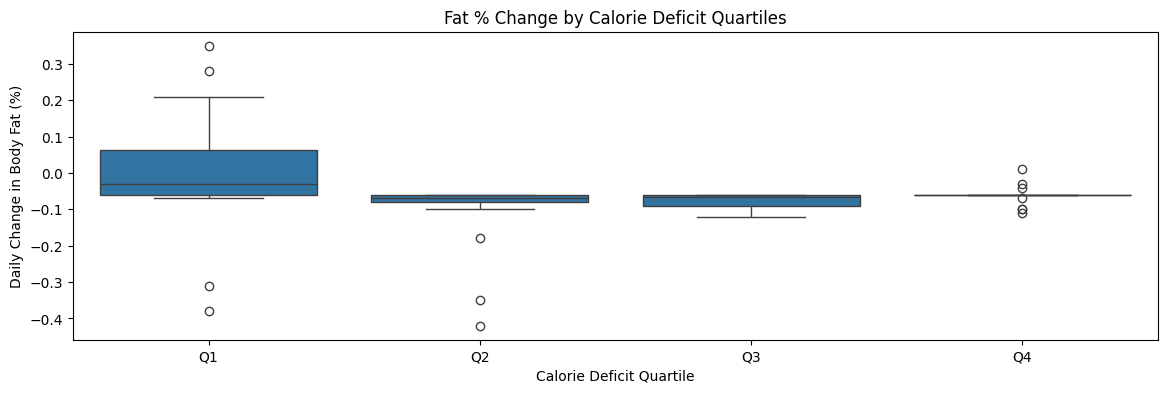

In [15]:
df["Deficit_Quartile"] = pd.qcut(df["Calorie Deficit (kcal)"], 4, labels=["Q1", "Q2", "Q3", "Q4"])

plt.figure(figsize=(14,4))
sns.boxplot(x="Deficit_Quartile", y="Fat % Change", data=df)
plt.title("Fat % Change by Calorie Deficit Quartiles")
plt.xlabel("Calorie Deficit Quartile")
plt.ylabel("Daily Change in Body Fat (%)")
plt.show()


➡️ The plot shows that individuals in the highest calorie deficit quartile (Q4) experienced the most consistent fat percentage reductions, with minimal variability.

➡️ In contrast, Q1 (lowest deficit) showed the widest range of changes, including both increases and decreases in body fat.

✅ This suggests that higher and sustained deficits may not only reduce fat more reliably but also stabilize day-to-day fluctuations, my second hypothesis is also about this.

**6. Hypothesis Testing**

**HYPOTHESIS 1: Calories vs Body Weight**
 
**H₀: Total daily caloric intake has no significant relationship with overall body weight.**

**H₁: Higher total caloric intake is significantly associated with increased body weight.**

**Method: Two sample t test with 0.05 significance level**

In [16]:
# Add next-day weight column
df["Weight_next"] = df["Body Weight (kg)"].shift(-1)

print("H2 | Calories vs Body Weight")

hi_mask = df["Daily Calorie Intake"] > 1700
lo_mask = df["Daily Calorie Intake"] < 1700

hi_w_next = df.loc[hi_mask, "Weight_next"].dropna()
lo_w_next = df.loc[lo_mask, "Weight_next"].dropna()

t_stat, p_val = ttest_ind(hi_w_next, lo_w_next, equal_var=False)

print(f"t-test  (Calories >1700 vs <1700, next-day weight): "
      f"t = {t_stat:.2f},  p = {p_val:.4f}")

if p_val < 0.05:
    print("Since p < 0.05, we reject the null hypothesis. Daily calorie intake significantly affects next-day weight.")
else:
    print("Since p ≥ 0.05, we fail to reject the null hypothesis — no significant difference found.")


H2 | Calories vs Body Weight
t-test  (Calories >1700 vs <1700, next-day weight): t = -2.09,  p = 0.0478
Since p < 0.05, we reject the null hypothesis. Daily calorie intake significantly affects next-day weight.


**HYPOTHESIS 2: Deficit vs Fat % Change**

**H₀: A daily caloric deficit does not significantly influence reductions in body fat percentage.**

**H₁: Consistent caloric deficits are significantly associated with reductions in body fat percentage.**

**Method: Pearson correlation with 0.05 significance level**

In [17]:
print("H2 | Calorie Deficit vs Fat % Change")

pear_r2, p2 = pearsonr(df["Calorie Deficit (kcal)"], df["Fat % Change"].fillna(0))
print(f"Pearson r = {pear_r2:.3f}  p = {p2:.12f}")

if p2 < 0.05:
    print("Since p < 0.05, we reject the null hypothesis. Consistent caloric deficits significantly influence fat % change.")
else:
    print("Since p ≥ 0.05, we fail to reject the null hypothesis — no significant relationship found.")

H2 | Calorie Deficit vs Fat % Change
Pearson r = -0.277  p = 0.013959231666
Since p < 0.05, we reject the null hypothesis. Consistent caloric deficits significantly influence fat % change.


**HYPOTHESIS 3: Protein Ratio vs Body Fat**

**H₀: The proportion of protein intake (relative to total calories) has no significant effect on body fat percentage reduction.**

**H₁: A higher proportion of protein intake is significantly associated with greater reductions in body fat percentage.**

**Method: Two sample t test with 0.05 significance level**

In [18]:
print("H3 | Protein Ratio vs Body Fat %")
prot_ratio = (df["Daily Protein Intake(g)"]*4) / df["Daily Calorie Intake"]
df["Protein Ratio"] = prot_ratio

hp = df[df["Protein Ratio"] > 0.30]["Body Fat Percentage (%)"]
lp = df[df["Protein Ratio"] < 0.18]["Body Fat Percentage (%)"]

t3, p3b = ttest_ind(hp, lp, equal_var=False)
print(f"t‑test (high vs low protein ratio): t = {t3:.2f}, p = {p3b:.4f}")

if p3b < 0.05:
    print("Since p < 0.05, we reject the null hypothesis — protein ratio significantly affects body fat %.")
else:
    print("Since p ≥ 0.05, we fail to reject the null hypothesis — no significant correlation found.")


H3 | Protein Ratio vs Body Fat %
t‑test (high vs low protein ratio): t = 0.37, p = 0.7224
Since p ≥ 0.05, we fail to reject the null hypothesis — no significant correlation found.


**HYPOTHESIS 4: Sleep Quality vs Fat‑Loss Success**

**H₀: Sleep duration and sleep quality have no significant influence on body fat percentage.**

**H₁: Longer sleep duration and better sleep quality is significantly associated with greater reductions in body fat percentage.**

**Method: Pearson correlation for sleep duration; Chi-square test for sleep quality. Significance level = 0.05.**

In [19]:
print("H4 | Sleep Duration vs Fat % Change")

mask = df["Sleep Duration (hours)"].notna() & df["Fat % Change"].notna()
r_sleep, p_sleep = pearsonr(df.loc[mask, "Sleep Duration (hours)"], df.loc[mask, "Fat % Change"])

print(f"Pearson r = {r_sleep:.3f}, p = {p_sleep:.4f}")

if p_sleep < 0.05:
    print("Since p < 0.05, we reject the null. Sleep duration significantly influences fat % change.")
else:
    print("Since p ≥ 0.05, we fail to reject the null — no significant relationship found.")

print()
print("H4 | Sleep Quality (Good vs Poor) vs Fat‑Loss Success")

df["Sleep Category"] = df["Sleep Quality"].apply(lambda x: "Good" if x >= 4 else ("Poor" if x <= 2 else "Mid"))

fat_success = df["Fat % Change"].apply(lambda x: 1 if x < 0 else 0)

df["Fat Success"] = fat_success

contingency = pd.crosstab(df["Sleep Category"], df["Fat Success"])

chi2, p_chi, dof, exp = chi2_contingency(contingency)
print(f"Chi‑square = {chi2:.2f}, p = {p_chi:.4f}")

if p_chi < 0.05:
    print("Since p < 0.05, we reject the null. Sleep quality and fat-loss success are associated.")
else:
    print("Since p ≥ 0.05, we fail to reject the null — no significant association found.")

H4 | Sleep Duration vs Fat % Change
Pearson r = -0.305, p = 0.0069
Since p < 0.05, we reject the null. Sleep duration significantly influences fat % change.

H4 | Sleep Quality (Good vs Poor) vs Fat‑Loss Success
Chi‑square = 8.45, p = 0.0147
Since p < 0.05, we reject the null. Sleep quality and fat-loss success are associated.
